# Medical Insurance Charges Project
***
***

# Goals
***
- Draw insights about what drives medical charges
- Create a machine learning model that can effectively predict medical costs

# Setup
***

In [171]:
# establishing environment
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Acquire
Acquiring the data for this project
***

In [172]:
# acquiring data from local csv downloaded from Kaggle
df = pd.read_csv('insurance.csv')

In [173]:
# previewing df
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Acquire Takeaways

- Downloaded data in CSV file from Kaggle
- Read data into notebook as DF

# Prepare
Preparing the data for exploration and modeling
***

In [174]:
# checking for null, data types, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Creating boolean columns for categorical variables

In [175]:
# creating dummy columns
df_dummies = pd.get_dummies(df, columns = ['sex', 'region' , 'smoker'], prefix = ['is','region', 'smoker'])

# renaming smoker column to match other binary column
df_dummies.rename(columns = {'smoker_yes' : 'is_smoker'}, inplace=True)

# resetting df indices otherwise merge causes extra rows to be created
df_dummies.reset_index(inplace = True)
df.reset_index(inplace = True)

# merging dummy df with main df
df = df.merge(df_dummies, how = 'inner')

# dropping these columns since their information is stored in counterpart column since they are binary values in this case
# ie. only male and female in data, if patient not female, must be male
# ie. if patient is a smoker, they must not be a non-smoker
# also dropping index here since passing drop argument to reset_index function also causes new row creation
df = df.drop(columns = ['is_male', 'smoker_no', 'index'])

df.head()

,age,sex,bmi,children,smoker,region,charges,is_female,region_northeast,region_northwest,region_southeast,region_southwest,is_smoker
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0,0,1,1
1,18,male,33.770,1,no,southeast,1725.55230,0,0,0,1,0,0
2,28,male,33.000,3,no,southeast,4449.46200,0,0,0,1,0,0
3,33,male,22.705,0,no,northwest,21984.47061,0,0,1,0,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,0,1,0,0,0


### Splitting dataframe in Train, Validate, and Test samples

In [176]:
# splitting data
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

### Checking Train, Validate, Test DF dimensions

In [177]:
train.shape, validate.shape, test.shape

((749, 13), (321, 13), (268, 13))

### Scale appropriate numerical columns

In [179]:
# creating scaler object
scaler = sklearn.preprocessing.MinMaxScaler()

# columns to scale
col_to_scale = ['age', 'bmi', 'children']
col_scaled_names = ['age_s', 'bmi_s', 'children_s']

# creating columns for scaled values
train['age_s'], train['bmi_s'], train['children_s'] = 0,0,0
validate['age_s'], validate['bmi_s'], validate['children_s'] = 0,0,0
test['age_s'], test['bmi_s'], test['children_s'] = 0,0,0

# fitting scaler to train column and scaling after
train[col_scaled_names] = scaler.fit_transform(train[col_to_scale])

# scaling data in validate and test dataframes
validate[col_scaled_names] = scaler.transform(validate[col_to_scale])
test[col_scaled_names] = scaler.transform(test[col_to_scale])

### Moving target variable, charges, to end of df

In [76]:
# removing charges column from df and saving as variable
charges_train, charges_val, charges_test = [train.pop('charges'), validate.pop('charges'), test.pop('charges')]
    
# adding back charges columns to end of DF
train['charges'] = charges_train
validate['charges'] = charges_val
test['charges'] = charges_test

KeyError: 'charges'

## Prepare Takeaways

__The following changes were made to the data__

- Scale non-target variable numerical columns
    - age
    - bmi
    - children

- Create boolean columns for categorical variables
    - sex
    - smoker
    - region

- Split data in train, validate, test sets

__Notes__

- No nulls to address

- Data types are appropriate for the operations I intend to perform on them

# Explore
Exploring the data to identify drivers of medical costs and variables that can be used as features in my model
***

## General Exploration

### Creating pairplot to see general relationships between all non-region variables

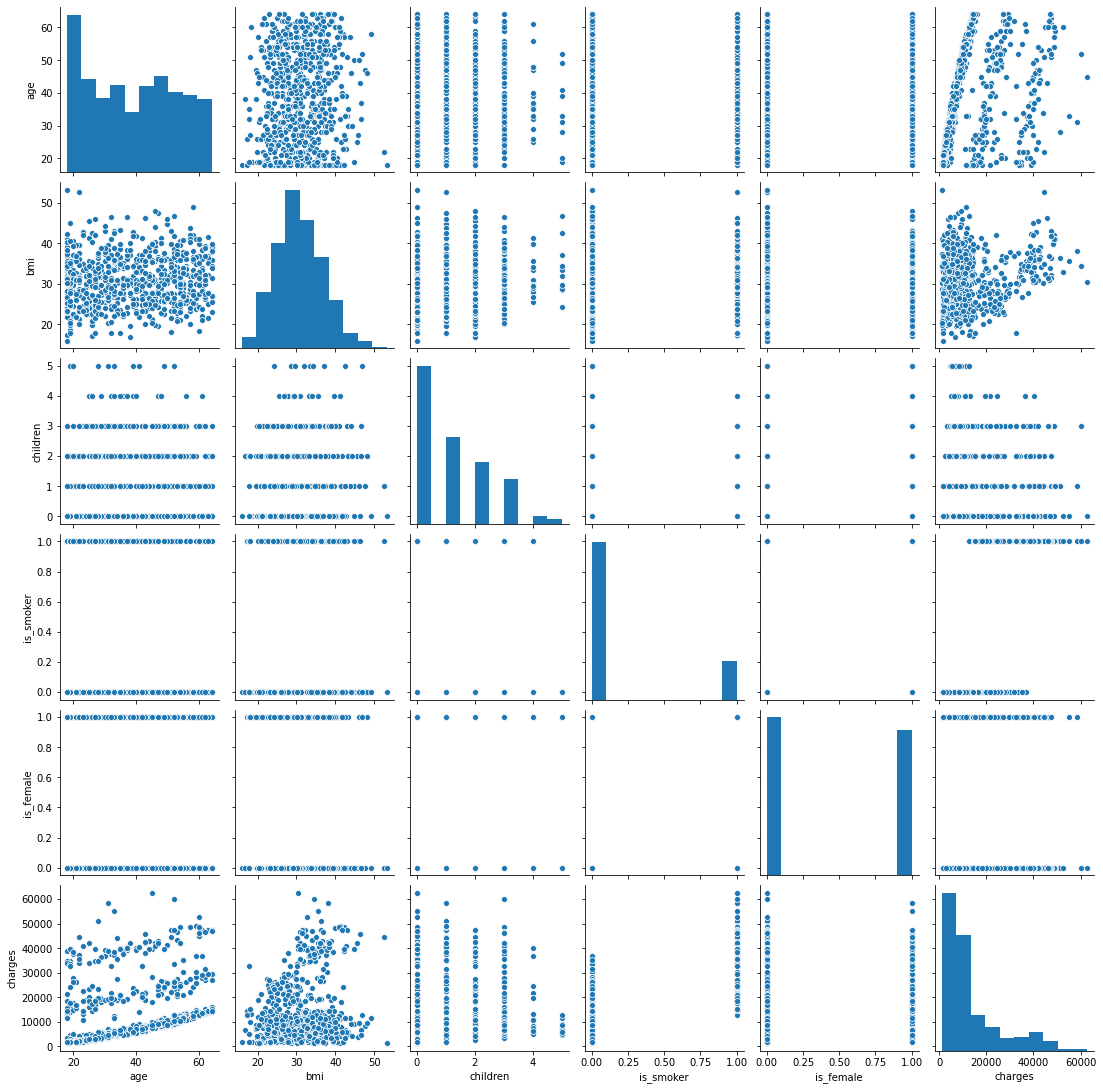

In [13]:
# creating df that only contains columns I want in pairplot
pairplot_df = train[['age', 'bmi', 'children', 'is_smoker', 'is_female', 'charges']]

# creating pairplot
sns.pairplot(pairplot_df)

__Age & Charges__
- Appear to be 3 distinct groups
    - 0 to 10k charges (points very close to each other)
    - 10k to 30k charges (points close but not as concentrated as 0 to 10k group)
    - 30k to 50k charges (visible grouping but weakest concentration)
- As age increases, so do charges

__Age & Children__
- Most patients appear to have 3 or less children

__Age & BMI__
- No discernable relationship

__BMI & Children__
- Most patients appear to have 3 or less children

__BMI & Charges__
- 30 to 45 BMI range appears to hold most of the higher charges

__Children & Charges__
- Patients with 5 children appear to have the lowest charges 

__Is_Smoker__
- No discernably strong relationships
- Ratio of smokers to non-smokers may vary significantly among genders and/or regions and is not discernable by these plots but I'll be examining their relationships more closely in a set of bar plots below

__Is_Female__
- No discernably strong relationships
- Ratio of male to female may vary significantly among smoker status and/or regions and is not discernable by these plots but I'll be examining their relationships more closely in a set of bar plots below

### Creating pairplot to see general relationships between all region variables and target variable, charges

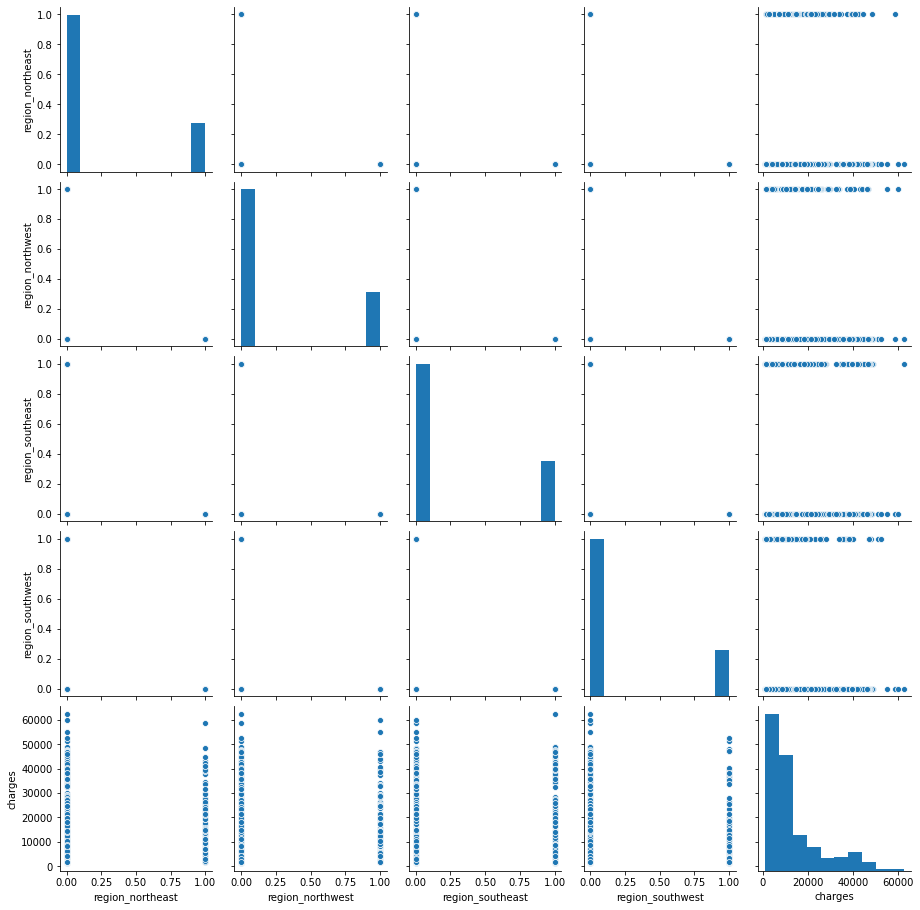

In [14]:
# creating df that only contains columns I want in pairplot
pairplot_df2 = train[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'charges']]

# creating pairplot
sns.pairplot(pairplot_df2)

__Charges & Regions__
- No discernablely strong relationships between regions and charges

### Creating barplots to more closely examine relationships between the categorical variables of sex, smoker status and region since the pairplots above wouldn't allow me to do so.

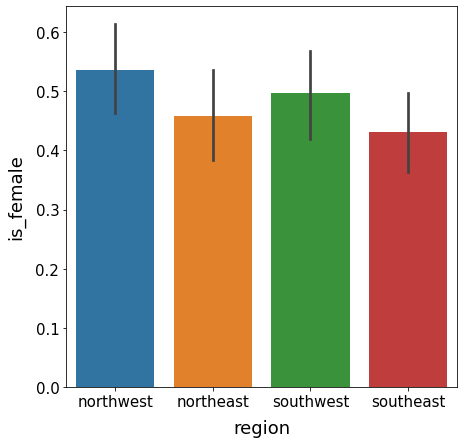

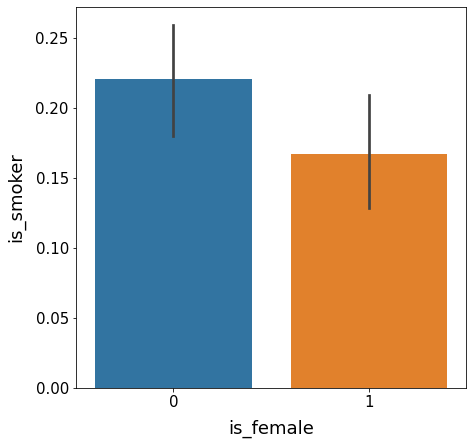

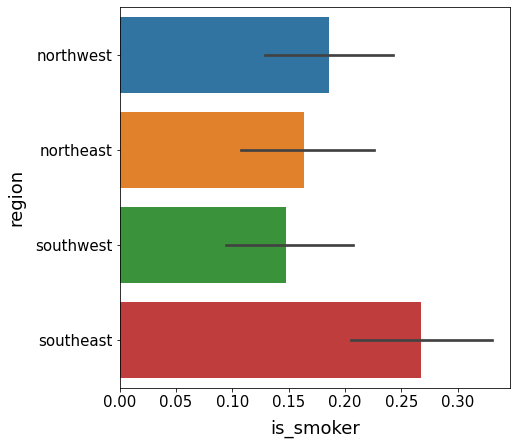

In [15]:
# filtering for only categorical columns
categorical_cols = train[['region', 'is_female', 'is_smoker']]

# setting counter for loop
counter = 1

# for loop creates barplots using every unique combination of variables
for col in categorical_cols.columns:
    if counter < len(categorical_cols.columns):
        plt.figure(figsize = (7,7))
        sns.barplot(data = categorical_cols, x = col, y = categorical_cols.iloc[:, categorical_cols.columns.get_loc(col)+1])
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.xlabel(f'{col}', fontsize=18, labelpad = 10)
        plt.ylabel(f'{categorical_cols.columns[categorical_cols.columns.get_loc(col)+1]}', fontsize=18, labelpad = 10)
        plt.show()
        counter += 1
    elif counter == len(categorical_cols.columns):
        plt.figure(figsize = (7,7))
        sns.barplot(data = categorical_cols, x = col, y = categorical_cols.iloc[:,0])
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.xlabel(f'{col}', fontsize = 18, labelpad = 10)
        plt.ylabel(f'{categorical_cols.columns[0]}', fontsize = 18, labelpad = 10)
        plt.show()
        counter += 1
    else:
        break

__Region & Gender__
- Females make up roughly 40-50% of the observations within each region

__Smoker & Gender__
- Roughly 5% more men smoke than women

__Region & Smoker__
- The southeast region has at least ~10% more smokers than any other region

### Creating a heatmap that includes each feature

<AxesSubplot:>

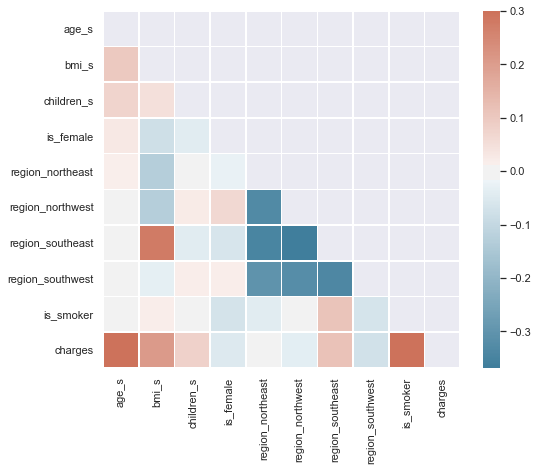

In [16]:
# setting figure size
sns.set(rc={'figure.figsize':(8,8)})

# specifying columns for heatmap
heatmap_df = train[['age_s', 'bmi_s', 'children_s', 'is_female', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'is_smoker', 'charges']]

# Compute the correlation matrix
corr = heatmap_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap=cmap, vmax=.3, center=0,
            square = True, linewidths=.5, cbar_kws={"shrink": .82})

The variables with the strongest correlations to charges appear to be
- age
- bmi
- is_smoker

## Focused Exploration: Age
### Visualization: Age

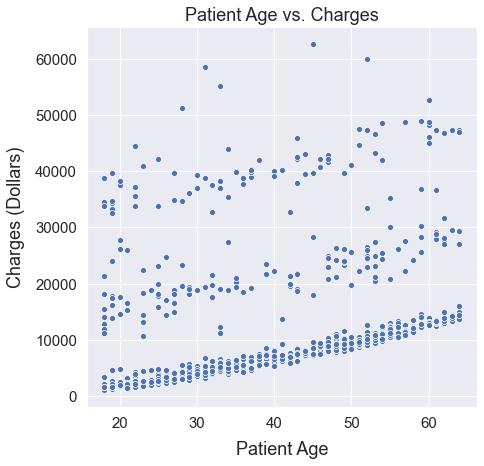

In [17]:
# creating scatterplot of age vs charges
plt.figure(figsize = (7,7))
sns.scatterplot(data = train, x = train.age, y = train.charges)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Patient Age', fontsize = 18, labelpad = 10)
plt.ylabel('Charges (Dollars)', fontsize = 18, labelpad = 10)
plt.title('Patient Age vs. Charges', fontsize = 18)

plt.show()

- There appear to be 3 groups
    - 0 to 10k charges (points very close to each other)
    - 10k to 30k charges (points close but not as concentrated as 0 to 10k group)
    - 30k to 50k charges (visible grouping but weakest concentration)
    - As age increases, so do the charges within each group

### Hypothesis Test: Age
Performing a pearson correlation test to see if there is a linear relationship between age and charges

H0: There is no linear relationship between age and charges 
<br>
Ha: There is a linear relationship between age and charges 

In [18]:
# performing pearson correlation test
corr, p = stats.pearsonr(train.age, train.charges)

# printing correlation coefficient and p value
print(f'alpha =                   0.05')
print(f'p =                       {p}')
print(f'correlation coeffecient = {corr}')

alpha =                   0.05
p =                       1.5635998069997362e-18
correlation coeffecient = 0.3133990600038662


- Since p is less than alpha I reject the null hypothesis that there is no linear relationship between age and charges
- Given the correlation coeffecient of .31, I conclude that there is a moderate, positive relationship between the variables.
    - In other words, generally speaking, as one variable increases, so does the other
    - One possibility is that as patients are aging, they are naturally requiring more medical care which is driving up their medical costs
- This may be a solid variable to use as a feature in modeling

## Focused Exploration: BMI
### Visualization: BMI

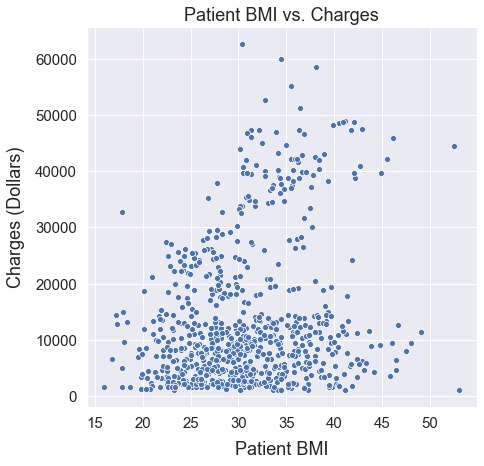

In [19]:
# creating scatterplot of bmi vs charges
plt.figure(figsize = (7,7))
sns.scatterplot(data = train, x = train.bmi, y = train.charges)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Patient BMI', fontsize = 18, labelpad = 10)
plt.ylabel('Charges (Dollars)', fontsize = 18, labelpad = 10)
plt.title('Patient BMI vs. Charges', fontsize = 18)

plt.show()

- 30 to 45 BMI range appears to hold most of the higher charges
- Only 1 patient below 25 BMI had more than 30000 in charges

### Hypothesis Test: BMI
Performing a pearson correlation test to see if there is a linear relationship between age and charges
<br>
<br>
H0: There is no linear relationship between BMI and charges 
<br>
Ha: There is a linear relationship between BMI and charges 

In [20]:
# performing pearson correlation test
corr, p = stats.pearsonr(train.bmi, train.charges)

# printing correlation coefficient and p value
print(f'alpha =                   0.05')
print(f'p =                       {p}')
print(f'correlation coeffecient = {corr}')

alpha =                   0.05
p =                       1.0838135248037468e-08
correlation coeffecient = 0.20697648494728077


- Since p is less than alpha, I reject the null hypothesis that there is no linear relationship between BMI and charges
- Given the correlation coeffecient of .20, I conclude that there is a moderate, positive relationship between the variables.
    - In other words, generally speaking, as one variable increases, so does the other
    - It may be that higher BMI's are corrolated with negative health conditions (heart disease, high blood pressure, etc) and are thus increasing the patient's needs for medical care, and their charges by extension
- This may be a solid variable to use as a feature in modeling

## Focused Exploration: Number of children
### Visualization: Number of children

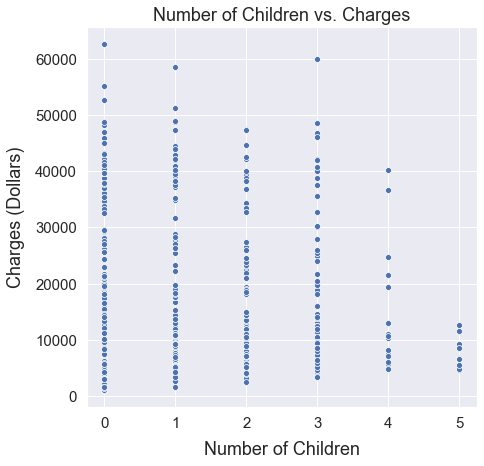

In [21]:
# creating scatterplot of number of children vs charges
plt.figure(figsize = (7,7))
sns.scatterplot(data = train, x = train.children, y = train.charges)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Number of Children', fontsize = 18, labelpad = 10)
plt.ylabel('Charges (Dollars)', fontsize = 18, labelpad = 10)
plt.title('Number of Children vs. Charges', fontsize = 18)

plt.show()

- Range of charges doesn't change too much until 5 children
    - Small range at 5 children could be due to the fact that there aren't many patients with 5 children so my sample may not be representing the distribution of charges for patients with 5 children very accurately

### Hypothesis Test: Number of children
Performing a pearson correlation test to see if there is a linear relationship between the number of children a patient has and charges
<br>
<br>
H0: There is no linear relationship between number of children and charges 
<br>
Ha: There is a linear relationship between number of children and charges 

In [22]:
# performing pearson correlation test
corr, p = stats.pearsonr(train.children, train.charges)

# printing correlation coefficient and p value
print(f'alpha =                   0.05')
print(f'p =                       {p}')
print(f'correlation coeffecient = {corr}')

alpha =                   0.05
p =                       0.02536384577198803
correlation coeffecient = 0.08169478213369147


- Since p is less than alpha, I reject the null hypothesis that there is no linear relationship between number of children and charges
- Given the correlation coeffecient of .08, I conclude that the relationship between the variables is so weak that it is nearly non-existent (since the coefficient is so close to 0)
    - In light of this, children probably won't be a good feature for modeling

## Focused Exploration: Gender
### Visualization: Gender

<AxesSubplot:title={'center':'Gender vs Charges'}, xlabel='Gender', ylabel='Charges'>

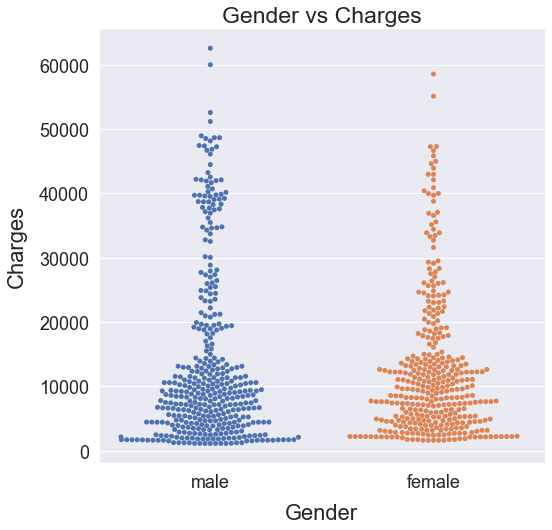

In [23]:
# creating swarmplot of gender vs charges
gender_df = train[['sex', 'charges']]
gender_df.columns = ['Gender', 'Charges']
plt.xlabel('Gender', fontsize = 22, labelpad = 12)
plt.ylabel('Charges (Dollars)', fontsize = 22, labelpad = 12)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Gender vs Charges', fontsize = 23)
sns.swarmplot(data = gender_df, x = 'Gender', y = 'Charges')

- Distribution of charges look very similar between both genders
    - There may be a few more males on the higher end of the charges range but probably not enough to make a significant difference overall.

### Hypothesis Test: Gender
Performing a two-sample, two-tailed t-test, to see if there is a significant difference between the average charges of men and women.
<br>
<br>
H0: The average charges of men = The average charges of women
<br>
Ha: The average charges of men != The average charges of women

In [24]:
male_df = train[train.sex == 'male']
female_df = train[train.sex == 'female']

t, p = stats.ttest_ind(male_df.charges, female_df.charges, equal_var = False)

print(f'alpha =                   0.05')
print(f'p =                       {p}')

alpha =                   0.05
p =                       0.17455815652159026


- Since p is greater than alpha, I fail to reject the null hypothesis
- The result of this test is evidence that there is no significant difference between the average charges of men and women
    - I speculate that although the medical needs of men and women may vary on average, the differences aren't having a significant impact on the average charges of each gender overall
- Gender does not appear to be strong candidate for use as a feature in modeling

## Focused Exploration: Region
### Visualization: Region

<AxesSubplot:title={'center':'Region vs Charges'}, xlabel='Region', ylabel='Charges'>

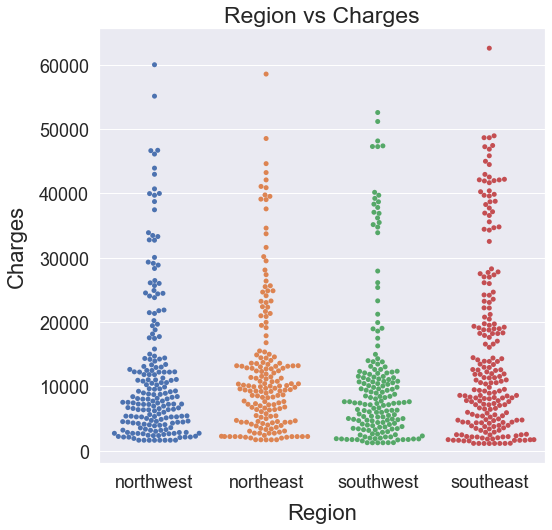

In [25]:
# creating swarmplot of region vs charges
gender_df = train[['region', 'charges']]
gender_df.columns = ['Region', 'Charges']
plt.xlabel('Region', fontsize = 22, labelpad = 12)
plt.ylabel('Charges (Dollars)', fontsize = 22, labelpad = 12)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Region vs Charges', fontsize = 23)
sns.swarmplot(data = gender_df, x = 'Region', y = 'Charges')

- Distribution of charges between each region seem fairly similar
- The southeast appears to have a few more patients with charges above 60000 

### Hypothesis Tests: Region

In [26]:
# isolating charges from each region
nw = train[train.region == 'northwest'].charges
ne = train[train.region == 'northeast'].charges
sw = train[train.region == 'southwest'].charges
se = train[train.region == 'southeast'].charges

__Anova Test for All 4 Regions__
<br>
H0: There is no difference in the average charges of each region
<br>
Ha: There is a difference in the average charges of each region

In [27]:
# performing ANOVA test
f, p = stats.f_oneway(nw, ne, sw, se)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.011405435904120432


- Given that p is below alpha, I'm rejecting the null hypothesis that there is no difference between the average charges of each region
    - However, this is __not to say that all of the regions have different charges__, just that at least one of them is different
    - Since the southeast region appears to be the region that is most unlike the others in terms of charges, I'm going to see what happens if I leave it out of the test

__Anova Test for All Regions except southeast__
<br>
H0: There is no difference in the average charges of the NW, NE, and SW regions
<br>
Ha: There is a difference in the average charges of the NW, NE, and SW regions

In [28]:
# performing ANOVA test
f, p = stats.f_oneway(nw, ne, sw)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.5431653089951874


- The p value is above alpha so I fail to reject the null hypothesis that there is no difference in the average charges of each of the included regions
- Given how substationally p increased, to the point that it was far above the alpha value, when the SE region was removed from the set of regions, it appears that the SE region's charges may be significantly different than the other region's
    - If this is the case, I speculate that either the average medical needs of people in the southeast are greater or the health care providers in the region charge more on average, or perhaps some combination thereof
- In light of this, region_southeast may be a solid candidate for use as a feature in modeling

## Focused Exploration: Smoker
### Visualization: Smoker

<AxesSubplot:title={'center':'Smoker vs Charges'}, xlabel='Smoker', ylabel='Charges'>

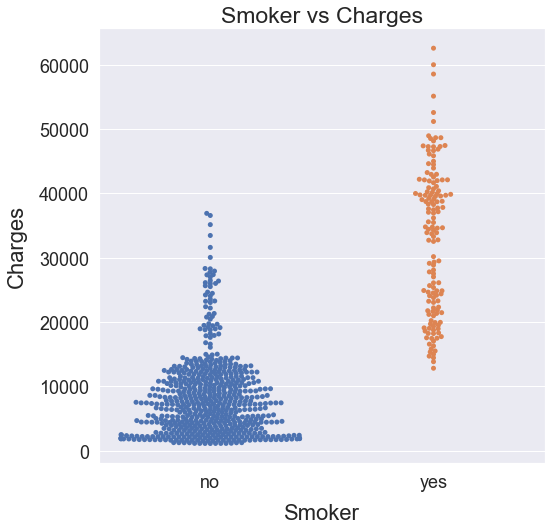

In [29]:
# creating swarmplot of gender vs charges
gender_df = train[['smoker', 'charges']]
gender_df.columns = ['Smoker', 'Charges']
plt.xlabel('Smoker', fontsize = 22, labelpad = 12)
plt.ylabel('Charges (Dollars)', fontsize = 22, labelpad = 12)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Smoker vs Charges', fontsize = 23)
sns.swarmplot(data = gender_df, x = 'Smoker', y = 'Charges')

- There appear to be a lot more non-smokers than smokers
- Smokers appear to have much higher charges on average than non-smokers

### Hypothesis Test: Smoker
Performing a two-sample, one-tailed t-test, to see if non-smokers have significantly lower charges than smokers.
<br>
<br>
H0: The average charges of non-smokers >= The average charges of smokers
<br>
Ha: The average charges of non-smokers < The average charges of smokers

In [30]:
# creating separate DFs for smokers and non0smoker
non_smokers = train[train.smoker == 'no']
smokers = train[train.smoker == 'yes']

# performing two-sample, one-tailed t-test
t, p = stats.ttest_ind(non_smokers.charges, smokers.charges, equal_var = False)

print(f'alpha =                   0.05')
print(f'p =                       {p/2}')
print(f't =                       {t}')

alpha =                   0.05
p =                       1.5738870807526403e-58
t =                       -25.021748437089684


- Since p is less than alpha and t is negative (for a "less than" test) I'm rejecting the null hypothesis that the average charges of non-smokers is equal to or greater than the average charges of smokers
    - If smoking is corrolated with higher charges, it may be due to fact that smoking has been linked to lung cancer and other horrible health conditions that are very expensive to treat
- Smoker status appears to be a strong candidate for use as a feature in modeling

## Explore Takeaways

- __Age__
    - Scatterplot suggested there are 3 general groups of patients that occupy different charge ranges
        - 0 to 10k charges (points very close to each other)
        - 10k to 30k charges (points close but not as concentrated as 0 to 10k group)
        - 30k to 50k charges (visible grouping but weakest concentration)
        - Generally, as age increases, so do the charges within each group
    - Performed a pearson correlation test and found that age and charges have a moderate positive relationship with each other
    
    
- __BMI__
    - Scatterplot reflected the following
        - 30 to 45 BMI range appears to hold most of the higher charges
        - Only 1 patient below 25 BMI had more than 30000 in charges
    - Pearson correlation test indicated there is a moderate positive relationship between charges and BMI
    
    
- __Children__
    - Scatterplot showed that charges only vary significantly change for patients with 5 children but this finding may be due to there not being many patients with least 5 children
    - Pearson correlation test reflect that there is a positive relationship between children and charges, it is almost non-existent
    

- __Gender__
    - Swarmplot showed very similar distribution of charges between men and women
        - There appear to be a few more males with higher charges than females but not many
    - Two-sample, two-tailed t-test suggested that there is no difference in between the average charges of males and females
  
  
- __Region__
    - Swamrplot showed very similar distributions between each region
        - Southeast region appears to have a several more patients with higher charges than the others
    - Anova test performed on all regions found that at least one of the regions average charges are significantly different than the others
    - Anova test performed on all regions except the southeast found that none of the regions had significantly different average charges than the others
    - This suggests that the Southeast is the region that had significantly different average charges in the original Anova test
    
    
- __Smoker__
    - Swarmplot showed a very strong distinction between smoker and non-smokers with regard to charges
        - Smokers appear to have much higher charges on average and there are far less of them than non-smokers
    - Two-sample, one-tailed t-test gave evidence that non-smokers have lower charges than smokers
    
 
- In light of the findings above, the variables below appear to be strong candidates for use as features in modeling
    - Age
    - BMI
    - Southeast (Region)
    - Smoker

## Modeling
***

## Train
Creating baseline and alternate models. The results from this phase will give an idea about how well my models perform on in-sample data. The two best models from this phase will be used on the validation data set.

### Baseline Model (Train)
Creating a baseline model that will always predict the patient's charges to be the average of the sample population.

In [31]:
# making baseline predictions
train['baseline_pred'] =  train['charges'].mean()

# evaluate rmse and print results
rmse_train_bl = round(mean_squared_error(train.charges, train.baseline_pred)**(1/2),6)
print("Baseline Model RMSE: ", rmse_train_bl)

Baseline Model RMSE:  12267.775092


### Model 1 - Linear Regression (Train)
Creating linear regression model that uses variables identified as strong candidates for features in modeling (smoker, southeast_region, bmi, age)

In [32]:
# select features for model 1 predictions and isolate target variable (charges)
x_m1_train = train[['is_smoker', 'region_southeast', 'bmi_s', 'age_s']]
y_m1_train = train[['charges']]

# creating linear regression object
lm = LinearRegression(normalize = True)

# fitting model to train data
lm.fit(x_m1_train, y_m1_train)

# predict charges with model 1
train['model_1_pred'] = lm.predict(x_m1_train)

# evaluate RMSE and print results
rmse_m1_train = round(mean_squared_error(train.charges, train.model_1_pred)**(1/2),6)
print("Model 1 RMSE: ", rmse_m1_train)

Model 1 RMSE:  6184.725556


### Model 2 - Lasso Lars (Train)
Creating Lasso Lars model that uses variables identified as strong candidates for features in modeling (smoker, southeast_region, bmi, age)

In [33]:
# select features for model 2 predictions and isolate target variable (charges)
x_m2_train = train[['is_smoker', 'region_southeast', 'bmi_s', 'age_s']]
y_m2_train = train[['charges']]

# creating lasso lars object
ll = LassoLars(alpha = 1.0)

# fitting model to train data
ll.fit(x_m2_train, y_m2_train)

# predict charges with model 2
train['model_2_pred'] = ll.predict(x_m2_train)

# evaluate RMSE and print results
rmse_m2_train = round(mean_squared_error(train.charges, train.model_2_pred)**(1/2),6)
print("model 2 RMSE: ", rmse_m2_train)

model 2 RMSE:  6185.015598


### Model 3 - Generalized Linear Model (Train)
Creating Tweedie Regressor model that uses variables identified as strong candidates for features in modeling (smoker, southeast_region, bmi, age)

In [34]:
# select features for model 3 predictions and isolate target variable (charges)
x_m3_train = train[['is_smoker', 'region_southeast', 'bmi_s', 'age_s']]
y_m3_train = train[['charges']]

# creating tweedie regressor object
tr = TweedieRegressor(power = 1, alpha = 0)

# fitting model to train data
tr.fit(x_m3_train, y_m3_train)

# predict charges with model 3
train['model_3_pred'] = tr.predict(x_m3_train)

# evaluate RMSE and print results
rmse_m3_train = round(mean_squared_error(train.charges, train.model_3_pred)**(1/2),6)
print("model 3 RMSE: ", rmse_m3_train)

model 3 RMSE:  6181.865395


__Model Performance Summary (Train)__

- Baseline Model
    - Type: Always predicts average charge of population
    - RMSE: 12267.775092
    
- Model 1
    - Type: Linear Regression
    - Features: is_smoker, region_southeast, bmi_s, age_s
    - RMSE: 6184.725556
    
- Model 2
    - Type: Lasso Lars
    - Features: is_smoker, region_southeast, bmi_s, age_s
    - RMSE:  6185.015598
    
- Model 3
    - Type: Generalized Linear Model
    - Features: is_smoker, region_southeast, bmi_s, age_s
    - RMSE: 6181.865395
    
Since model 1 and model 3 have the best (lowest) RMSE values, I'm going to move forward with them onto the validation sample.

## Validate
This phase will give me an idea about how well my models will perform on out-of-sample data. I'll also be tunning the hyperparameters of my models during this phase.

### Model 1 - Tuning Hyper Parameters
__UPDATE__: After adjusting every appropriate parameter listed in the documentation for LinearRegression, I was not able to produce a RMSE value lower than when I use the hyperparameter settings from the original model. In light of this, no hyperparameters will be changed from the train version of this model.

In [35]:
# creating linear regression object and adjusting hyperparameters
lm = LinearRegression(normalize = True)

# fitting model to train data
lm.fit(x_m1_train, y_m1_train)

LinearRegression(normalize=True)

### Model 1 - Linear Regression (Validate)

In [36]:
# select features for model 1 predictions and isolate target variable (charges)
x_m1_val = validate[['is_smoker', 'region_southeast', 'bmi_s', 'age_s']]
y_m1_val = validate[['charges']]

# predict charges with model 1
validate['model_1_pred'] = lm.predict(x_m1_val)

# evaluate RMSE and print results
rmse_m1_val = round(mean_squared_error(validate.charges, validate.model_1_pred)**(1/2),6)
print("Model 1 RMSE: ", rmse_m1_val)

Model 1 RMSE:  6274.595291


### Model 3 - Tuning Hyper Parameters
__UPDATE__: Like the case of model 2, after attempting to tune the hyperparameters of model 3, I was not able produce any RMSE values that were lower than the RMSE value produced by the hyperparameter settings I used on the train set. In light of this, I won't be changing model 3's hyperparameters from what they were originally.

In [37]:
# creating tweedie regressor object
tr = TweedieRegressor(power=1, alpha=0)

# fitting model to train data
tr.fit(x_m3_train, y_m3_train)

TweedieRegressor(alpha=0, power=1)

### Model 3 - Generalized Linear Model (Validate)

In [38]:
# select features for model 3 predictions and isolate target variable (charges)
x_m3_val = validate[['is_smoker', 'region_southeast', 'bmi_s', 'age_s']]
y_m3_val = validate[['charges']]

# predict charges with model 3
validate['model_3_pred'] = tr.predict(x_m3_val)

# evaluate RMSE and print results
rmse_m3_val = round(mean_squared_error(validate.charges, validate.model_3_pred)**(1/2),6)
print("model 3 RMSE: ", rmse_m3_val)

model 3 RMSE:  5893.477794


__Model Performance Summary (Validate)__

- Model 1
    - Type: Linear Regression
    - Features: is_smoker, region_southeast, bmi_s, age_s
    - RMSE: 6274.595291
    
- Model 3
    - Type: Generalized Linear Model
    - Features: is_smoker, region_southeast, bmi_s, age_s
    - RMSE:  5893.477794
    
Since model 3 produced the best (lowest) RMSE values, I'm going to move forward with them onto the test sample.

## Test
I will use my best model, model 3, to predict the charges in the test sample

### Model 3 - Generalized Linear Model (Test)

In [39]:
# select features for model 3 predictions and isolate target variable (charges)
x_m3_test = test[['is_smoker', 'region_southeast', 'bmi_s', 'age_s']]
y_m3_test = test[['charges']]

# predict charges with model 3
test['model_3_pred'] = tr.predict(x_m3_test)

# evaluate RMSE and print results
rmse_m3_test = round(mean_squared_error(test.charges, test.model_3_pred)**(1/2),6)
print("model 3 RMSE: ", rmse_m3_test)

model 3 RMSE:  5095.42626


__Model Performance Summary (Test)__

- Model 3
    - Type: Generalized Linear Model
    - Features: is_smoker, region_southeast, bmi_s, age_s
    - RMSE:  5095.42626

## Conclusion
***

- __Acquire__
    - Downloaded data from kaggle as csv
    - Read data into notebook as DF
    
    
- __Prepare__
    - Scaled non-target variable numerical columns
        - age
        - bmi
        - children
    - Created boolean columns for categorical variables
       - sex
       - smoker
       - region
    - Split data in train, validate, test sets
    - No nulls to address
    - Data types were appropriate for the operations I performed
    
    
- __Explore__
    - Through the use of plots and hypothesis tests, the following variables were found to be strong candidates for use as features in modeling to predict charges
        - Age
        - BMI
        - Southeast (Region)
        - Smoker
        
        
- __Modeling__
    - Best Model
        - Type: Generalized Linear Model
        - Features:
            - Age
            - BMI
            - Southeast (Region)
            - Smoker
        - Train (In-Sample) RMSE: 6181.865395
        - Validate (Out-of-Sample) RMSE: 5893.477794
        - Test (Out-of-Sample) RMSE: 5095.42626